In [130]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ligo.skymap.plot
from astropy import units as u
from astropy.coordinates import SkyCoord
from ligo.gracedb.rest import GraceDb
from ligo.skymap.io import read_sky_map
import tempfile
from scipy.stats import norm
import os
import subprocess

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 7})

In [2]:
def LSST_mag_lim(C_m,m_sky,theta_eff,t_vis,k_m,X):
    '''
    C_m is the band dependent parameter
    m_sky is the sky brightness (AB mag arcsec−2)
    theta_eff is the seeing (in arcseconds)
    t_vis is the exposure time (seconds)
    k_m is the atmospheric extinction coefficient
    X is air mass
    '''
    return C_m + 0.5 * (m_sky-21) + 2.5*np.log10(0.7/theta_eff)+1.25*np.log10(t_vis/30)-k_m*(X-1)

def getLSSTBandParameters(band):
    # Band dict in the form of band: [C_m,m_sky,theta_eff,k_m]
    # From eq. 6 of Ivecic 2019
    bandDict = {"u":[23.09,22.99,0.92,0.491],
                "g":[24.42,22.26,0.87,0.213],
                "r":[24.44,21.20,0.83,0.126],
                "i":[24.32,20.48,0.80,0.096],
                "z":[24.16,19.60,0.78,0.069],
                "y":[23.73,18.61,0.76,0.170],
               }
    return bandDict[band.lower()]

In [3]:
local=300

In [211]:
gdb = GraceDb()

galplane_buffer = 10 # The upper and lower limit on the galactic latitude range - typically, this is 15 degrees
galplane_lat = np.append(np.arange(0,359,step=1)-180/np.pi, [])

galplane_md = np.full(np.shape(galplane_lat), 0)
galplane_lo = np.full(np.shape(galplane_lat), -galplane_buffer)
galplane_hi = np.full(np.shape(galplane_lat), galplane_buffer)

galplane_md_coords = SkyCoord(l=galplane_lat*u.degree, b=galplane_md*u.degree, frame='galactic')
galplane_lo_coords = SkyCoord(l=galplane_lat*u.degree, b=galplane_lo*u.degree, frame='galactic')
galplane_hi_coords = SkyCoord(l=galplane_lat*u.degree, b=galplane_hi*u.degree, frame='galactic')

galaxyKwargs = {"Center": {'ls':"--",
                           'color':'black',
                           "alpha":0.7,
                           'label':"Galactic centerline",
                           "linewidth":2},
                "Upper limit": {'ls':"--",
                                "color":'black',
                                'alpha':0.3,
                                'label':"Galactic latitude limit +/- {} deg".format(galplane_buffer),
                                "linewidth":1.5},
                "Lower limit": {'ls':"--",
                                "color":'black',
                                'alpha':0.3,
                                "linewidth":1.5}}

In [9]:
superevent_ids = []
# with open(f"superevents_{local}.txt","r") as f:
with open("DES_footprint_GWTC4.txt","r") as f:
    lines = f.readlines()
    for l in lines:
        
        superevent_ids.append(l.split(" ")[0])

In [66]:
kys = np.sort(superevent_ids)
GWTC_4_skymap_dict = {}
for k in kys:
    GWTC_4_skymap_dict[str(k)]=None

In [227]:
GWTC_4_skymap_dict["GW170809"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW170809_082821_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW170814"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW170814_103043_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW190503"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW190503_185404_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW190701"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW190701_203306_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW190814"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW190814_211039_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW191204"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC3p0-v2-GW191204_171526_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW191230"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC3p0-v2-GW191230_180458_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW200219"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC3p0-v2-GW200219_094415_PEDataRelease_cosmo_reweight_C01:Mixed.fits'
GWTC_4_skymap_dict["GW200311"] = '/Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC3p0-v2-GW200311_115853_PEDataRelease_cosmo_reweight_C01:Mixed.fits'

In [228]:
nside=1024

In [231]:
desMap = hp.ud_grade(hp.read_map("/Users/sean/Desktop/Repos/plotMaker/data/DES/des_y3_gold_footprint_128.fits"),1024)
desMapMasked = np.zeros(len(desMap))
desMapMasked[desMap>0] = 1

In [ ]:
# dist_cut = 1015.7 # This is for z=0.2
# dist_cut = 1607.6 # This is for z=0.3

for dist_cut,z in zip([1015.6,1607.5,2246.7,2927.6],[0.2,0.3,0.4,0.5]):
    # This is designed to work for the GW superevent IDs
    cumulative_area = 0
    nevents = 0
    combined_skymap = np.zeros(hp.nside2npix(1024), dtype=float)
    skymaps = []
    level_arr90 = []
    level_arr50 = []
    ids = []
    zmeans = []
    zstds = []
    ras = []
    decs = []
    distance_cdfs = []
    
    for ky,val in zip(GWTC_4_skymap_dict.keys(),GWTC_4_skymap_dict.values()):
    
        print(f"Retrieving skymap {ky}")
        
        # with tempfile.NamedTemporaryFile(delete=False) as tmp:
        #     data = gdb.files(myId, 'bayestar.fits.gz').read()
        #     tmp.write(data)
        #     tmp_path = tmp.name
        tmp_path = val
            
        skymap = read_sky_map(val)
    
        if len(skymap)!=12582912:
            # Need to flatten the skymap
            print(f"Need to flatten the skymap for {ky}")
            with tempfile.NamedTemporaryFile(delete=False) as tmp2:
                subprocess.run(["ligo-skymap-flatten","--nside","1024", f"{tmp_path}", f"{tmp2.name}"]) 
                # os.remove(tmp_path)
                tmp_path = tmp2.name
            skymap = read_sky_map(tmp_path,distances=True)[0][0]
            distanceMap = read_sky_map(tmp_path,distances=True)[0][2]
            distanceSigMap = read_sky_map(tmp_path,distances=True)[0][3]
    
        dist_cdf = []
        for mu,sig in zip(distanceMap,distanceSigMap):
            dist_cdf.append(norm.cdf(dist_cut,loc=mu,scale=sig))
        
        combined_skymap += skymap*dist_cdf
    
        sorted_probs = np.flipud(np.sort(skymap))
        levels = np.cumsum(sorted_probs)
        index90 = np.searchsorted(levels, 0.90)
        level_arr90.append(sorted_probs[index90])
        index50 = np.searchsorted(levels, 0.50)
        level_arr50.append(sorted_probs[index50])
        skymaps.append(skymap)
        distance_cdfs.append(dist_cdf)
    
        # os.remove(tmp_path)
    
    fig = plt.figure(figsize=[10,6],dpi=300)
    ax = plt.subplot(projection='geo degrees mollweide',center='0h0m -0d')
    ax.grid()
    cax = ax.imshow_hpx(np.power(combined_skymap*desMapMasked,1),smooth=0.1*u.deg,cmap='cylon')
    # Galactic plane plotting
    for coord, label, galkey in zip([galplane_md_coords, galplane_lo_coords, galplane_hi_coords],
                                    ["Galactic center", "Galactic lower limit", "Galactic upper limit"],
                                    galaxyKwargs.keys()):
            galRa = coord.icrs.ra
            galDec = coord.icrs.dec
            ax.plot(np.array(galRa)-90, galDec,transform=ax.get_transform('icrs'), **galaxyKwargs[galkey])
    # Skymap contours
    for i in range(len(skymaps)):
        ax.contour_hpx(skymaps[i], smooth=0.25*u.deg, levels=[level_arr50[i]],linestyles='-', linewidths=1, colors='#ff4500')
        ax.contour_hpx(skymaps[i], smooth=0.25*u.deg, levels=[level_arr90[i]],linestyles='-.', linewidths=1, colors='#ff4500')
    ax.contour_hpx(desMapMasked,  levels=1,linestyles='-', linewidths=1.25, colors='#836fff')
    fig.colorbar(cax,ax=ax,location='bottom',label=rf"Localization probability $\times$ CDF up to $z$={z} Mpc")
    fig.tight_layout()
    fig.savefig(f"DES_O4b_CDF_z_{z}.jpg",dpi=300)
    # ax.set_xlim((-50*u.deg).to_value(u.rad),(100*u.deg).to_value(u.rad))
    # ax.set_ylim(-85*u.deg,10*u.deg)

Retrieving skymap GW170809
Need to flatten the skymap for GW170809


2025-11-28 15:23:36,257 INFO reading FITS file /Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW170809_082821_PEDataRelease_cosmo_reweight_C01:Mixed.fits
2025-11-28 15:23:36,393 INFO writing FITS file /var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/tmp8wnkva0o
/Users/sean/.local/share/mamba/envs/pittgoogle-py311/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2148: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Retrieving skymap GW170814
Need to flatten the skymap for GW170814


2025-11-28 15:27:46,263 INFO reading FITS file /Users/sean/Desktop/Repos/plotMaker/data/GWTC-4/GWTC_4_DES_skymaps/IGWN-GWTC2p1-v2-GW170814_103043_PEDataRelease_cosmo_reweight_C01:Mixed.fits
2025-11-28 15:27:46,382 INFO writing FITS file /var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/tmpxv2kluu9
/Users/sean/.local/share/mamba/envs/pittgoogle-py311/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2148: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
# This does the skymaps from the local list of .txt
cumulative_area = 0
nevents = 0
combined_skymap = np.zeros(hp.nside2npix(1024), dtype=float)
skymaps = []
level_arr90 = []
level_arr50 = []
ids = []
zmeans = []
zstds = []
ras = []
decs = []

for myId in superevent_ids:

    print(f"Retrieving skymap {myId}")
    
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        data = gdb.files(myId, 'bayestar.fits.gz').read()
        tmp.write(data)
        tmp_path = tmp.name
        
    skymap = read_sky_map(tmp_path)[0]

    if len(skymap)!=12582912:
        # Need to flatten the skymap
        print(f"Need to flatten the skymap for {myId}")
        with tempfile.NamedTemporaryFile(delete=False) as tmp2:
            subprocess.run(["ligo-skymap-flatten","--nside","1024", f"{tmp_path}", f"{tmp2.name}"]) 
            # os.remove(tmp_path)
            tmp_path = tmp2.name

    skymap = read_sky_map(tmp_path)[0]
    
    combined_skymap += skymap

    sorted_probs = np.flipud(np.sort(skymap))
    levels = np.cumsum(sorted_probs)
    index90 = np.searchsorted(levels, 0.90)
    level_arr90.append(sorted_probs[index90])
    index50 = np.searchsorted(levels, 0.50)
    level_arr50.append(sorted_probs[index50])
    skymaps.append(skymap)

    # os.remove(tmp_path)

CPU times: user 3.04 s, sys: 486 ms, total: 3.53 s
Wall time: 3.53 s


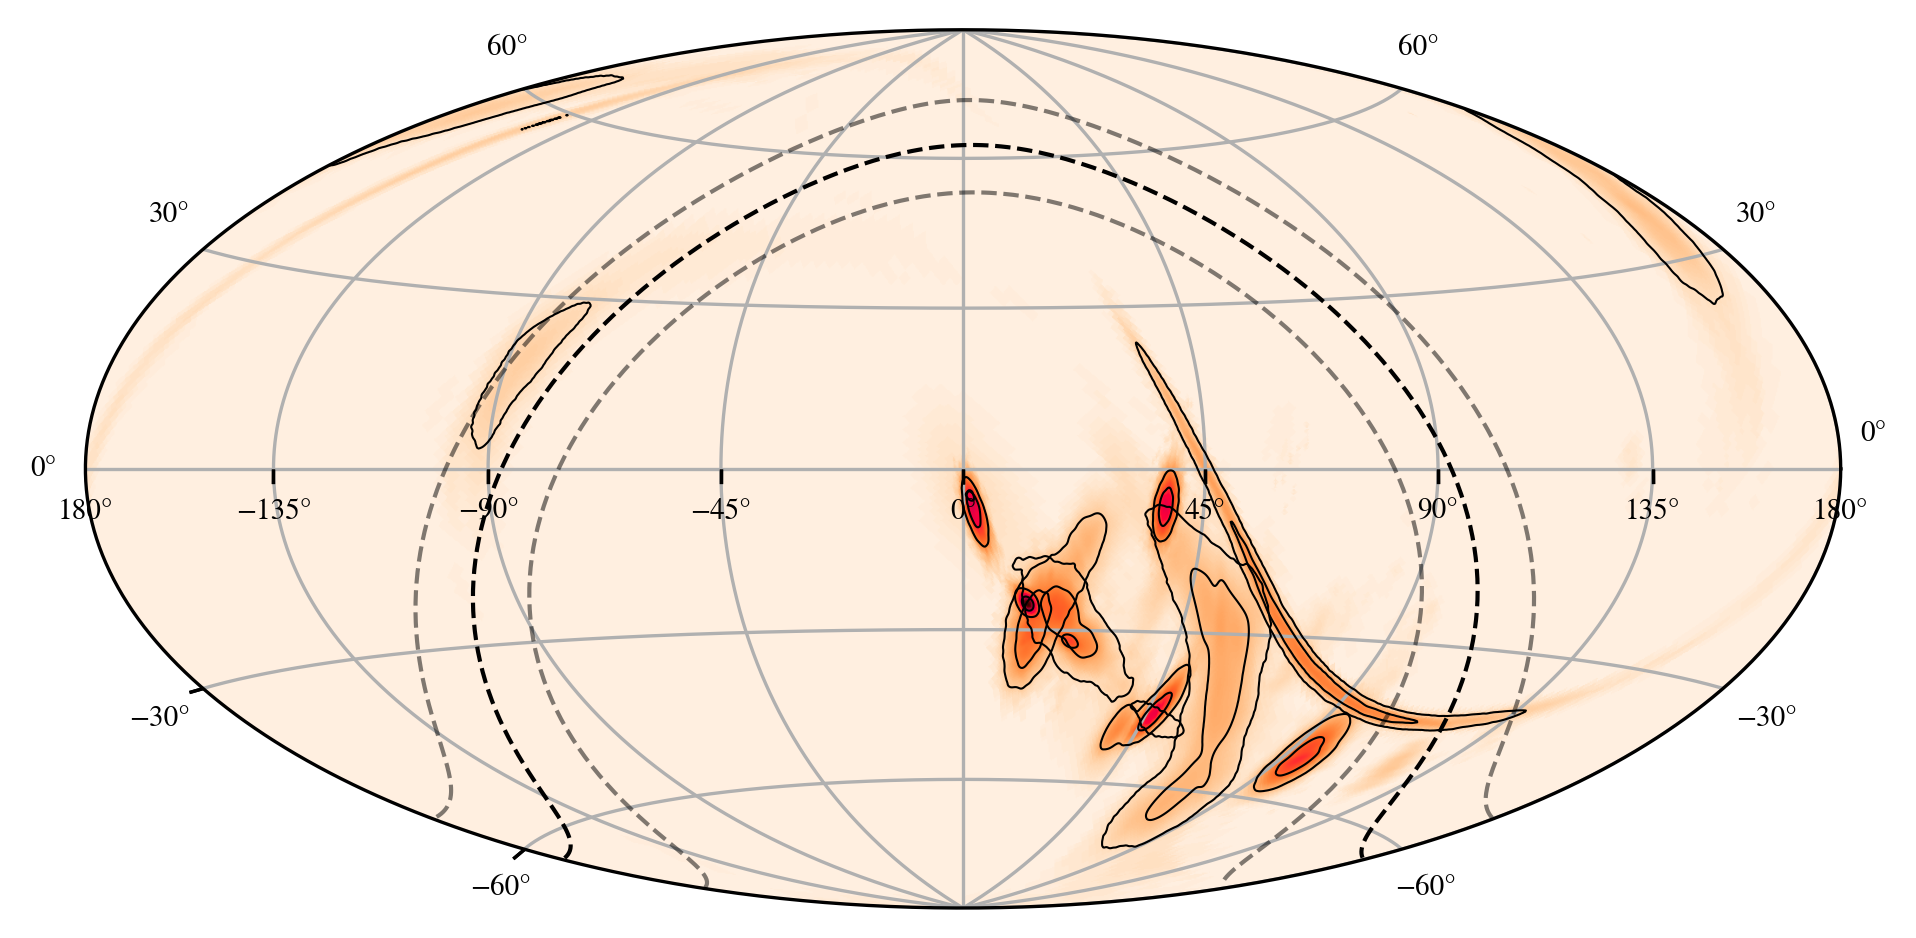

In [92]:
%%time 
fig = plt.figure(dpi=300)
ax = plt.subplot(projection='geo degrees aitoff')
ax.grid()

ax.imshow_hpx(combined_skymap**0.5, cmap='cylon')

for coord, label, galkey in zip([galplane_md_coords, galplane_lo_coords, galplane_hi_coords],
                                ["Galactic center", "Galactic lower limit", "Galactic upper limit"],
                                galaxyKwargs.keys()):
        galRa = coord.icrs.ra
        galDec = coord.icrs.dec
        ax.plot(np.array(galRa)-90, galDec, linewidth=1, transform=ax.get_transform('icrs'), **galaxyKwargs[galkey])


for i in range(len(skymaps)):
    # print(ky)
    ax.contour_hpx(skymaps[i], smooth=0.25*u.deg, levels=[level_arr90[i],level_arr50[i]], linewidths=0.5, colors='#000000')
    # ax.text(ras[i], decs[i], ids[i], color='k', fontsize=4, ha='center', transform=ax.get_transform('world'))

fig.tight_layout()
plt.savefig(os.path.join(os.getcwd(),f"combinedSkymap_DESFootprint.jpg"),dpi=300)

### LSST specific stuff

In [10]:
visits_per_yr = np.array([56, 74, 184, 187, 166, 171])/10 # visits per year in u-g-r-i-z-y
expTimes = [38,30,30,30,30,30]
X = 1.3 # SDSS average, for reference
allBands = ["u","g","r","i","z","y"]

In [11]:
# DES limits in grizy: 24.7 24.4 23.8 23.1 21.7

In [12]:
DESLims = [24.7, 24.4, 23.8, 23.1, 21.7]

In [13]:
for band, expT,deslim in zip(allBands[1:],expTimes[1:],DESLims):
    nvis=0
    C_m,m_sky,theta_eff,k_m = getLSSTBandParameters(band)
    while LSST_mag_lim(C_m,m_sky,theta_eff,expT*nvis,k_m,X)<deslim:
        nvis+=1
    print(f"LSST {band} band visits equivalent to DES Y6: {nvis}")
    nvis+=1
    print(f"For safety, use {nvis} visits, corresponding to {LSST_mag_lim(C_m,m_sky,theta_eff,expT*nvis,k_m,X):2.2f}")

LSST g band visits equivalent to DES Y6: 1
For safety, use 2 visits, corresponding to 25.13
LSST r band visits equivalent to DES Y6: 2
For safety, use 3 visits, corresponding to 24.91
LSST i band visits equivalent to DES Y6: 1
For safety, use 2 visits, corresponding to 24.26
LSST z band visits equivalent to DES Y6: 1
For safety, use 2 visits, corresponding to 23.70
LSST y band visits equivalent to DES Y6: 1
For safety, use 2 visits, corresponding to 22.77


/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_81004/526887051.py:10: RuntimeWarning: divide by zero encountered in log10
  return C_m + 0.5 * (m_sky-21) + 2.5*np.log10(0.7/theta_eff)+1.25*np.log10(t_vis/30)-k_m*(X-1)


In [90]:
df = pd.read_csv("_DP2(1).ecsv",skiprows=13,delimiter=' ')

In [91]:
df

band        s_ra      s_dec  exp_time img_type science_program  \
0        g  304.336354 -22.791246      30.0  science       BLOCK-365   
1        z  347.218565 -11.486688      30.0  science       BLOCK-365   
2        r  331.991544 -16.131214      30.0  science       BLOCK-365   
3        z  344.765395 -12.840158      30.0  science       BLOCK-365   
4        r  299.204668 -18.509802      30.0  science       BLOCK-365   
...    ...         ...        ...       ...      ...             ...   
14704    i  309.599338 -25.364438      30.0  science       BLOCK-365   
14705    i  296.727756 -23.737502      30.0  science       BLOCK-365   
14706    i  295.117916 -20.930280      30.0  science       BLOCK-365   
14707    i  301.612796 -21.834505      30.0  science       BLOCK-365   
14708    i  314.395925 -22.951871      30.0  science       BLOCK-365   

         observation_reason target_name  scheduler_note  
0             pairs_gr_33.0     lowdust  pair_33, gr, a  
1      template_blob_z_33.0     lowdust    templates, z  
2      template_blob_r_33.0     lowdust    templates, r  
3      template_blob_z_33.0     lowdust    templates, z  
4      template_blob_r_33.0     lowdust    templates, r  
...                     ...         ...             ...  
14704  template_blob_i_33.0     lowdust    templates, i  
14705         pairs_ri_33.0     lowdust  pair_33, ri, a  
14706         pairs_ri_33.0     lowdust  pair_33, ri, a  
14707         pairs_ri_33.0     lowdust  pair_33, ri, a  
14708         pairs_ri_33.0     lowdust  pair_33, ri, a  

[14709 rows x 9 columns]

In [92]:
perVisDict = {'u': 5.6, 
'g': 7.4,
'r': 18.4,
'i':  18.7,
'z':  16.6,
'y':  17.1}

In [93]:
DESLims = {"u":2,"g":2,"r":3,"i":2,"z":2,"y":2}

<>:35: SyntaxWarning: invalid escape sequence '\O'
<>:35: SyntaxWarning: invalid escape sequence '\O'
/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_81004/364369640.py:35: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title("{} band, $\Omega_{}={:.2f} \deg ^2$".format(b,"D",DESArea))
/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_81004/364369640.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


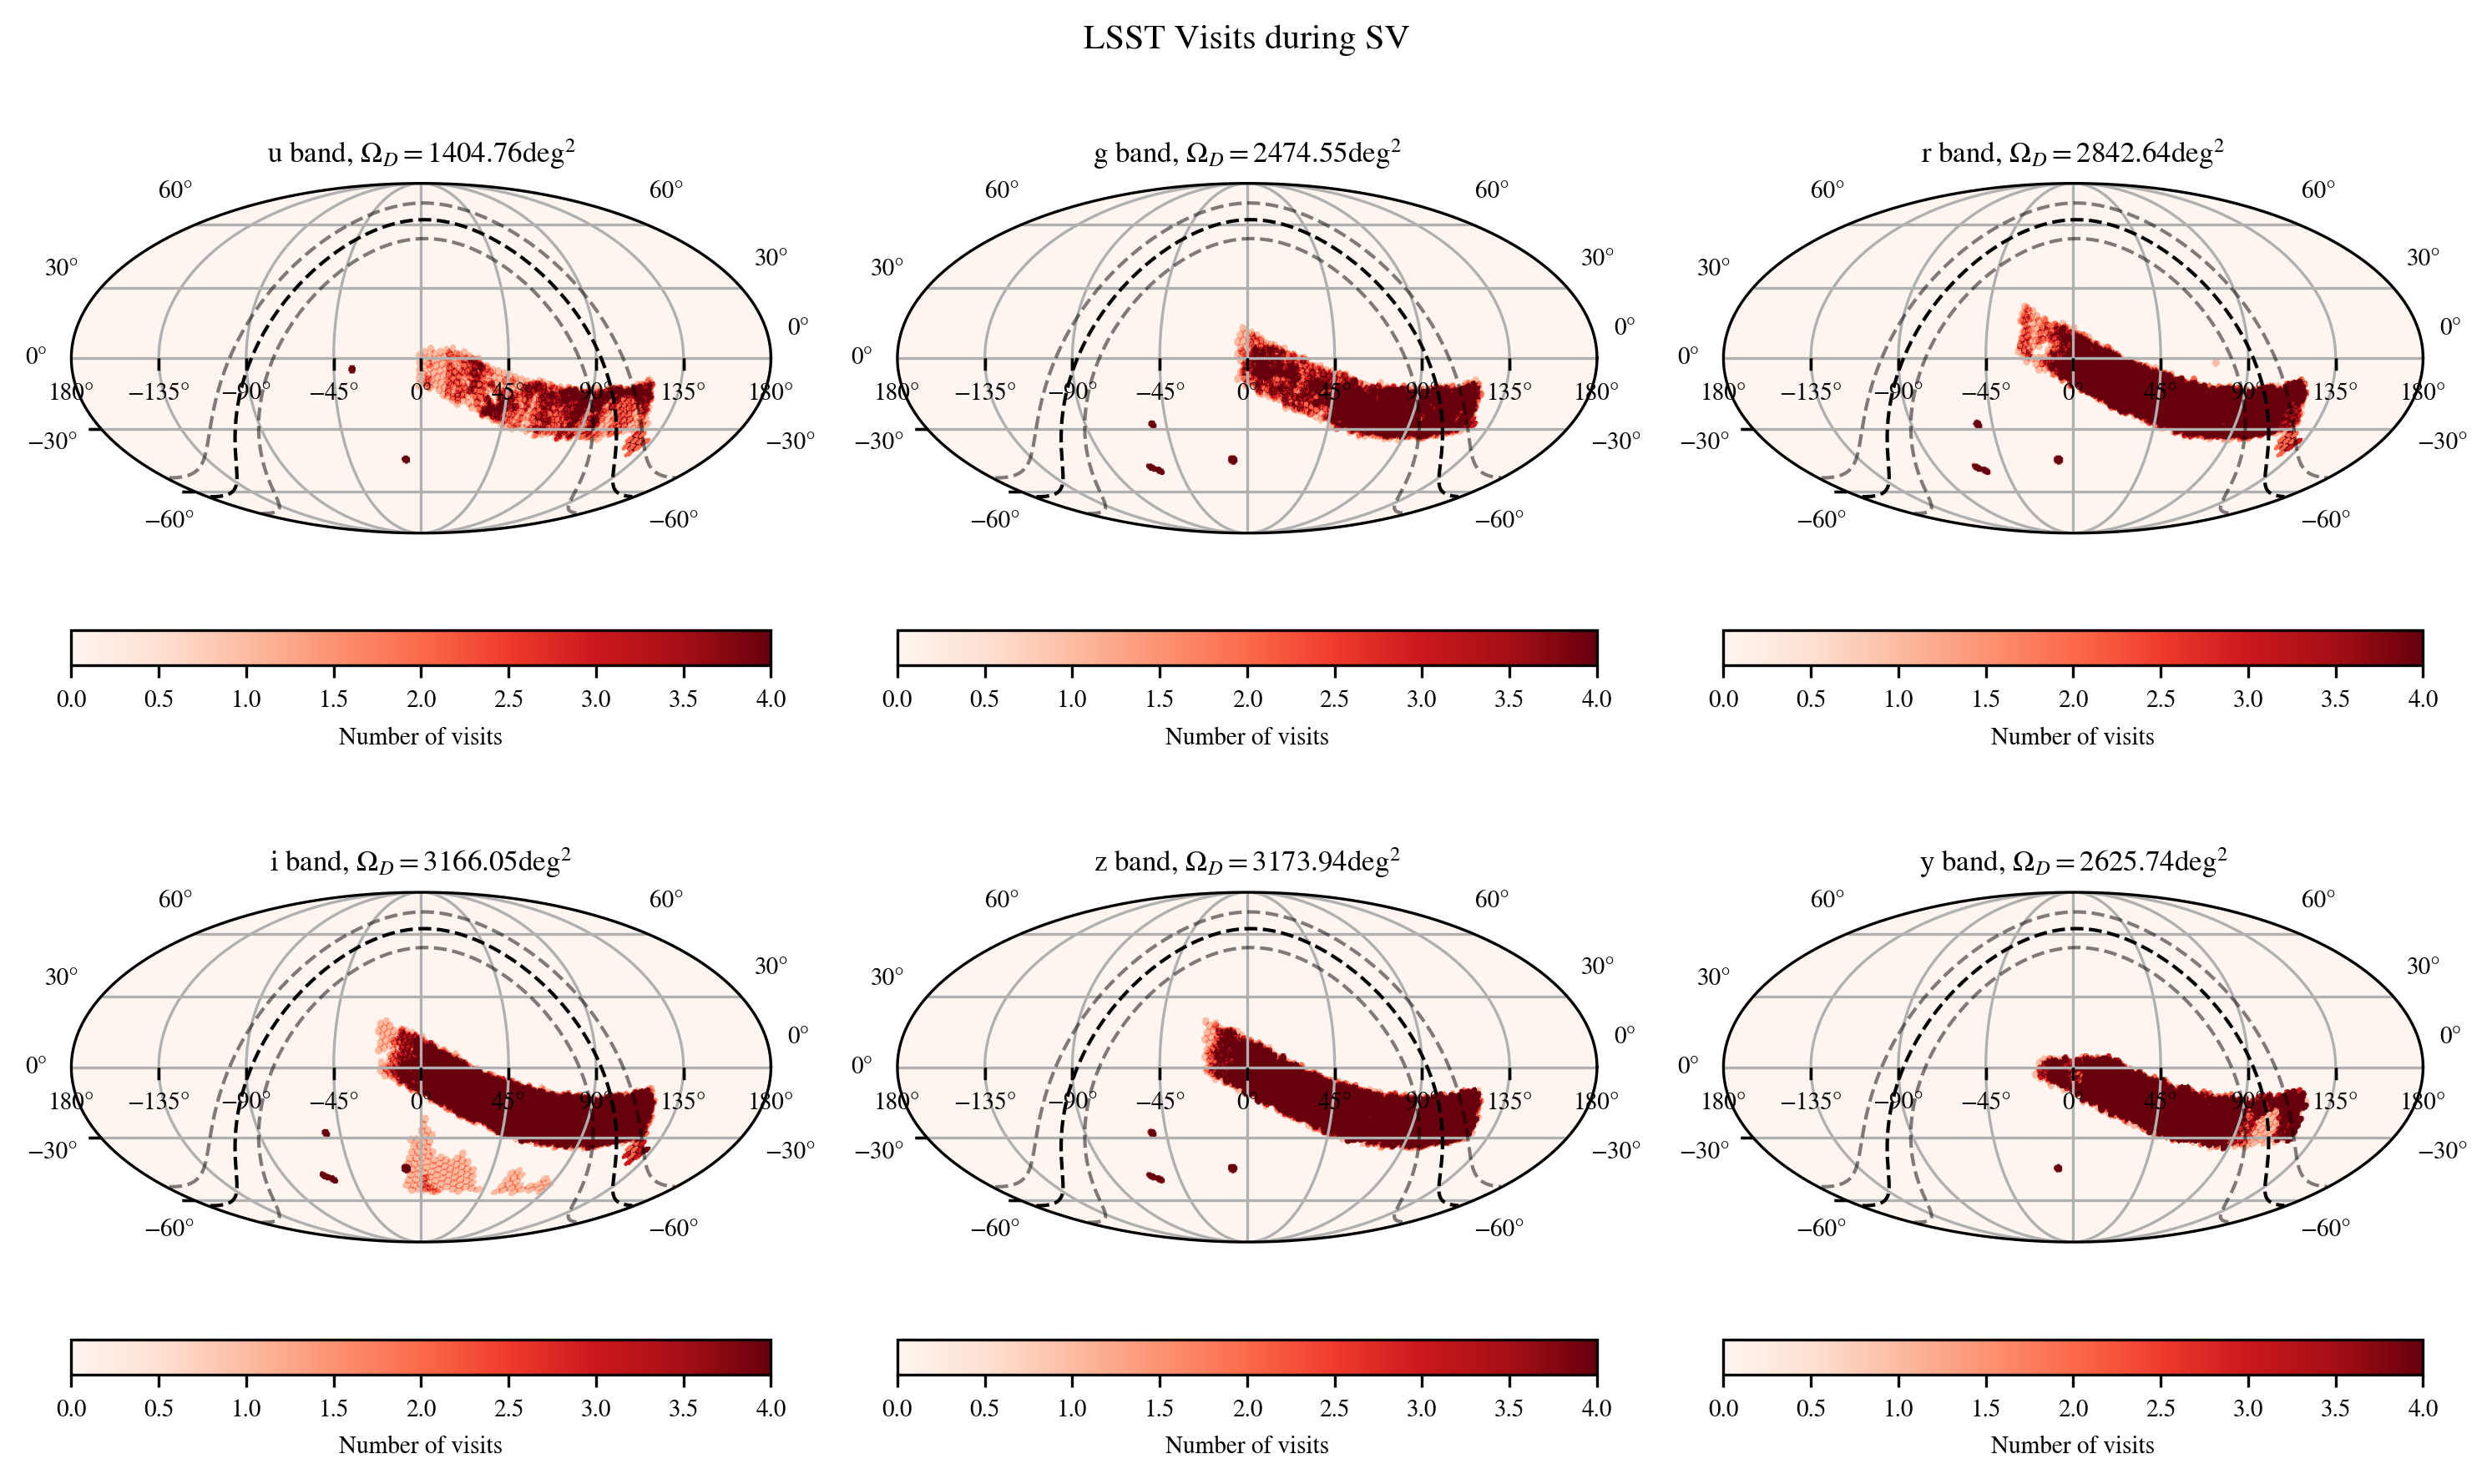

In [101]:
# %%time
visitMaps = {}

fig, axs = plt.subplots(2,3,dpi=300,figsize=[10,6],subplot_kw={'projection': "geo degrees mollweide"})
for b,ax,DESVisitEquiv in zip(DESLims.keys(),axs.flatten(),DESLims.values()):
    
    
    msk = df['band']==b
    nvisMap = np.zeros(hp.nside2npix(nside))

    for index,row in df[msk].iterrows():
        discIndices = hp.query_disc(nside,hp.ang2vec(-row['s_ra'],row['s_dec'],lonlat=True),np.deg2rad(1.75),inclusive=True)
        nvisMap[discIndices]+=1
    
    # nvisMap = nvisMap/perVisDict[b]
    
    y1msk = nvisMap>1
    y1Area = hp.nside2pixarea(nside,degrees=True)*len(nvisMap[y1msk])

    DESMsk = nvisMap>DESVisitEquiv
    DESArea = hp.nside2pixarea(nside,degrees=True)*len(nvisMap[DESMsk])
    # nvisMap[~DESMsk]=0

    for coord, label, galkey in zip([galplane_md_coords, galplane_lo_coords, galplane_hi_coords],
                                ["Galactic center", "Galactic lower limit", "Galactic upper limit"],
                                galaxyKwargs.keys()):
        galRa = coord.icrs.ra
        galDec = coord.icrs.dec
        ax.plot(np.array(galRa)-90, galDec, linewidth=1, transform=ax.get_transform('icrs'), **galaxyKwargs[galkey])

    
    c = ax.imshow_hpx(nvisMap,vmin=0,vmax=4,cmap="Reds")
    fig.colorbar(c,ax=ax,location='bottom',label="Number of visits")
    
    ax.set_title("{} band, $\Omega_{}={:.2f} \deg ^2$".format(b,"D",DESArea))
    ax.grid()

    visitMaps[b] = nvisMap

fig.suptitle("LSST Visits during SV",fontsize='x-large')
fig.tight_layout()
fig.show()
plt.savefig("LSST_DP2_DES.png",dpi=300)

In [102]:
bandSet = ["grz","griz","ugriz","ugrizy"]

<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:33: SyntaxWarning: invalid escape sequence '\O'
/var/folders/d8/d_92b22d1r57n7wy2ct3n7xr0000gn/T/ipykernel_81004/126574701.py:33: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title("{} band coincidence, $\Omega_{}={:.2f} \deg ^2$".format(bandGroup,"D",coincArea))
/Users/sean/.local/share/mamba/envs/lsst-scipipe/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:248: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/sean/.local/share/mamba/envs/lsst-scipipe/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:248: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/sean/.local/share/mamba/envs/lsst-scipipe/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:248: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = su

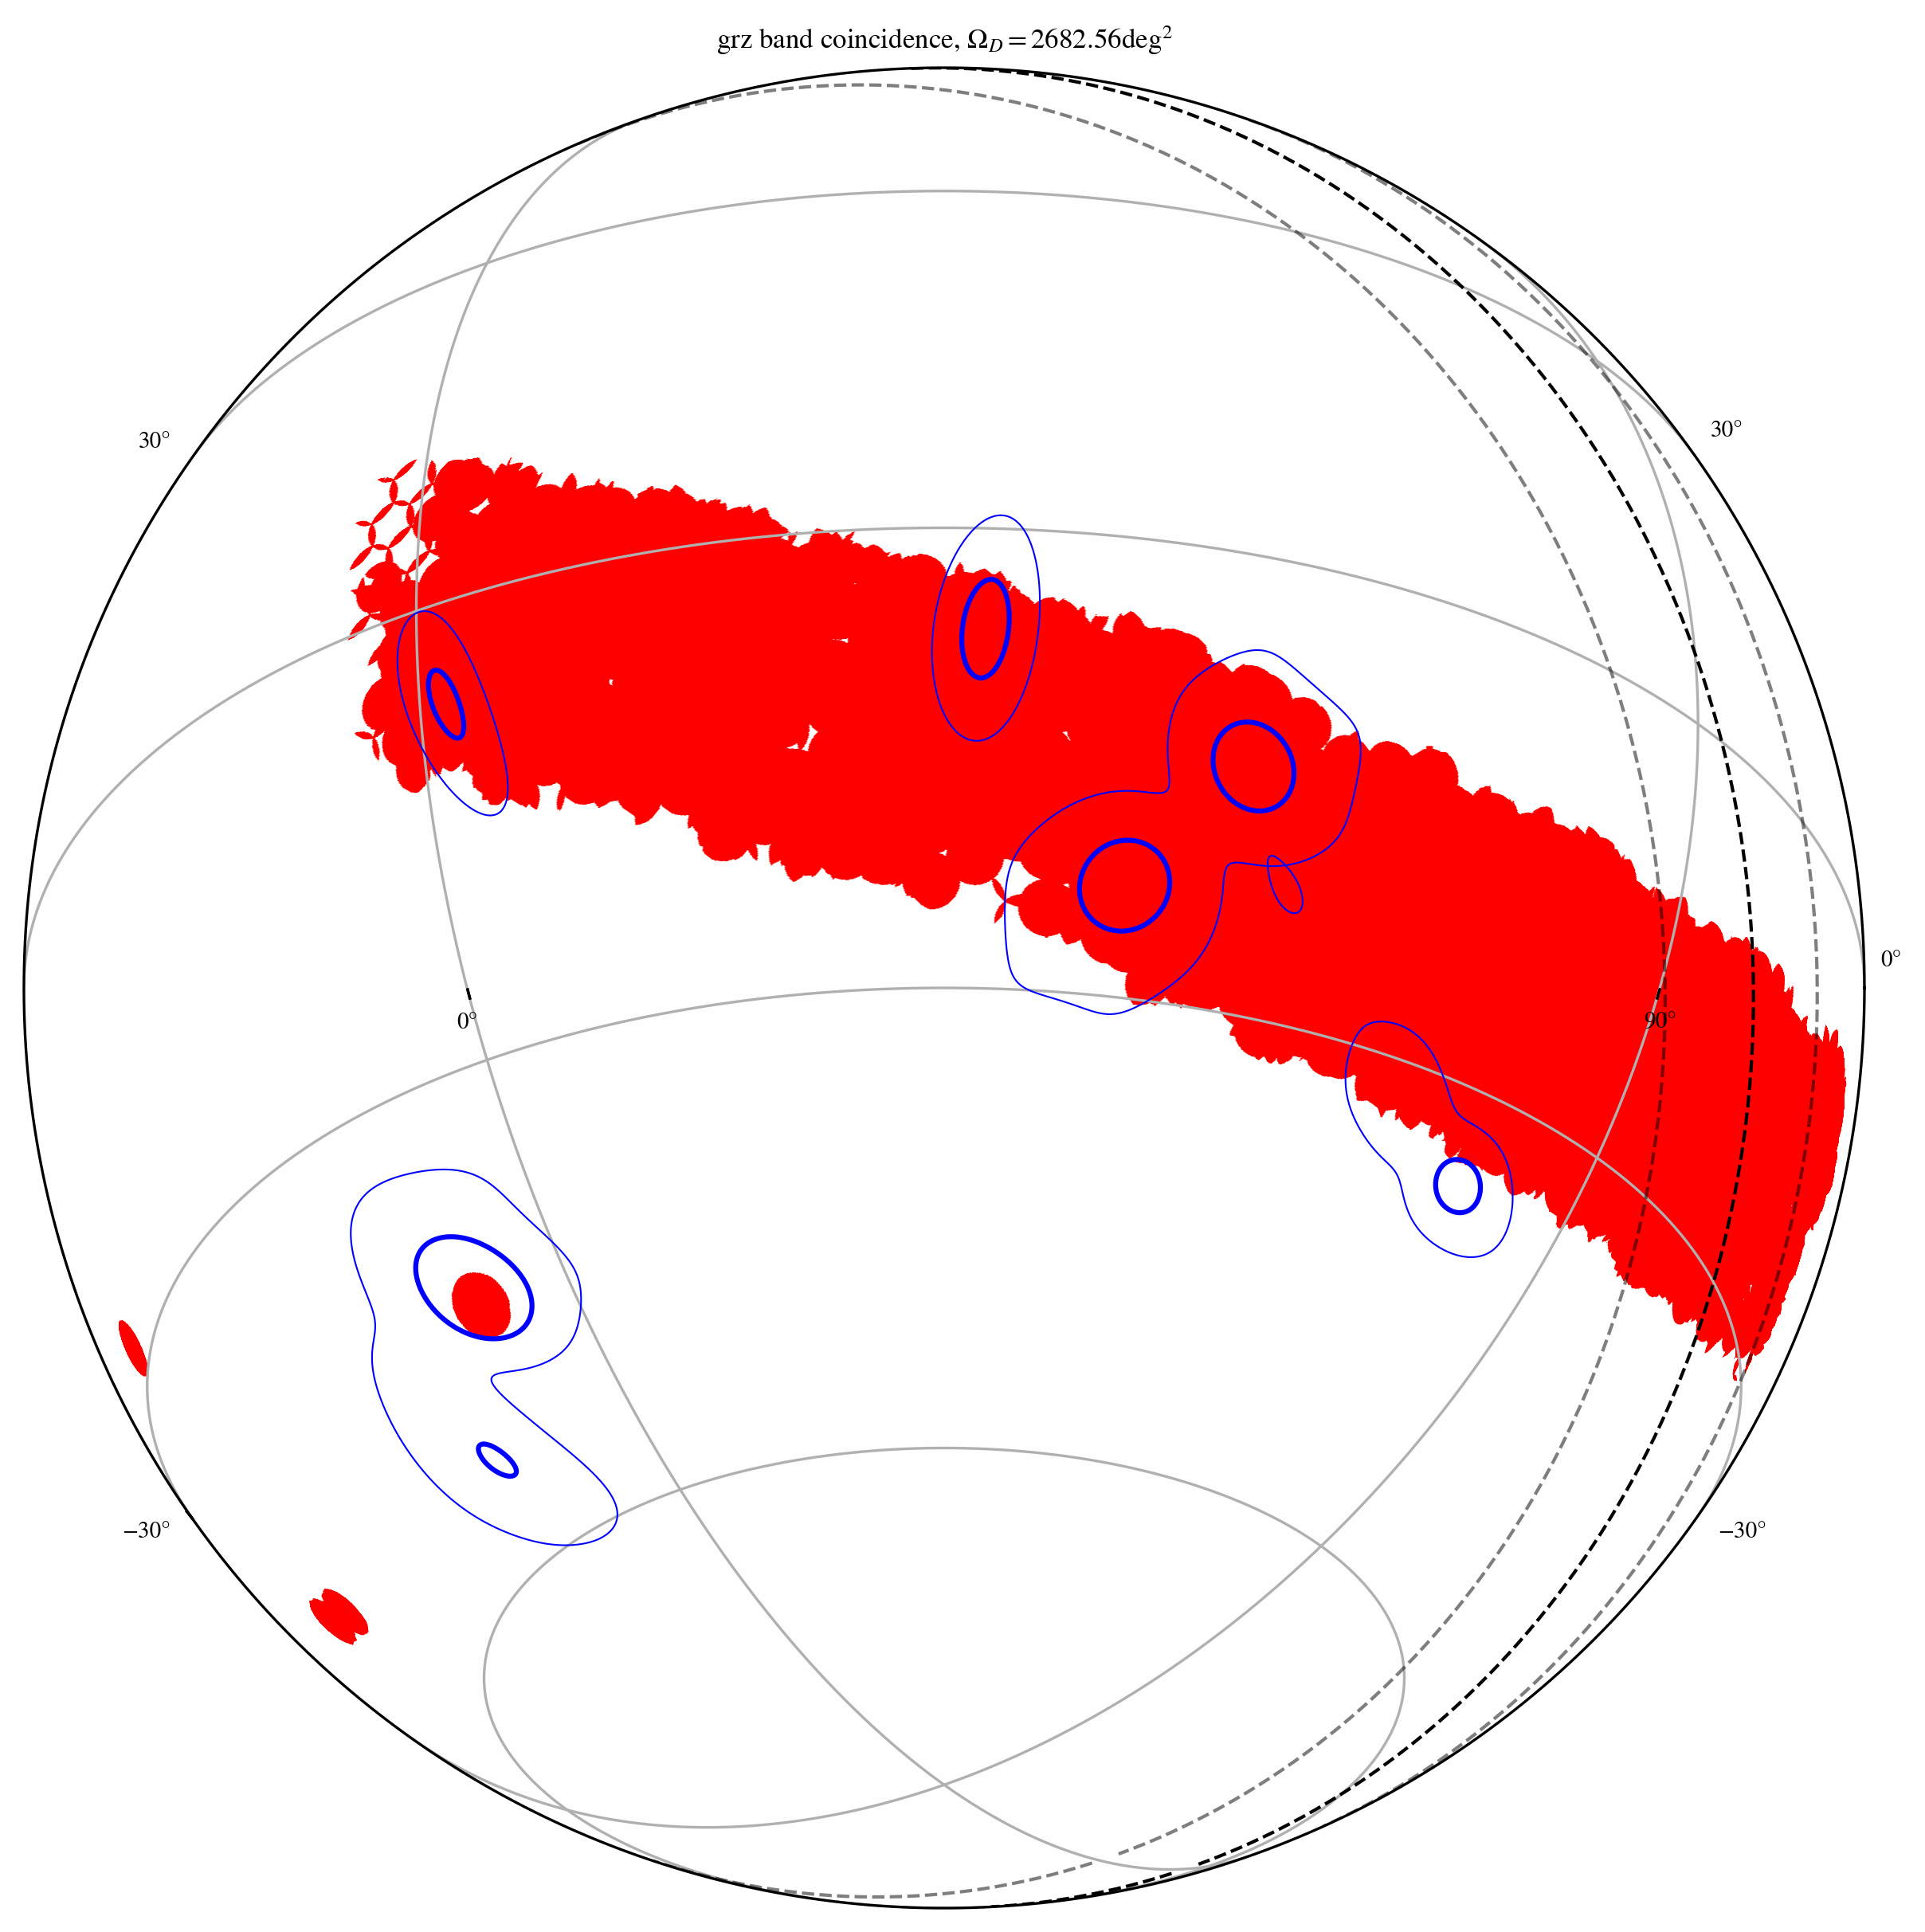

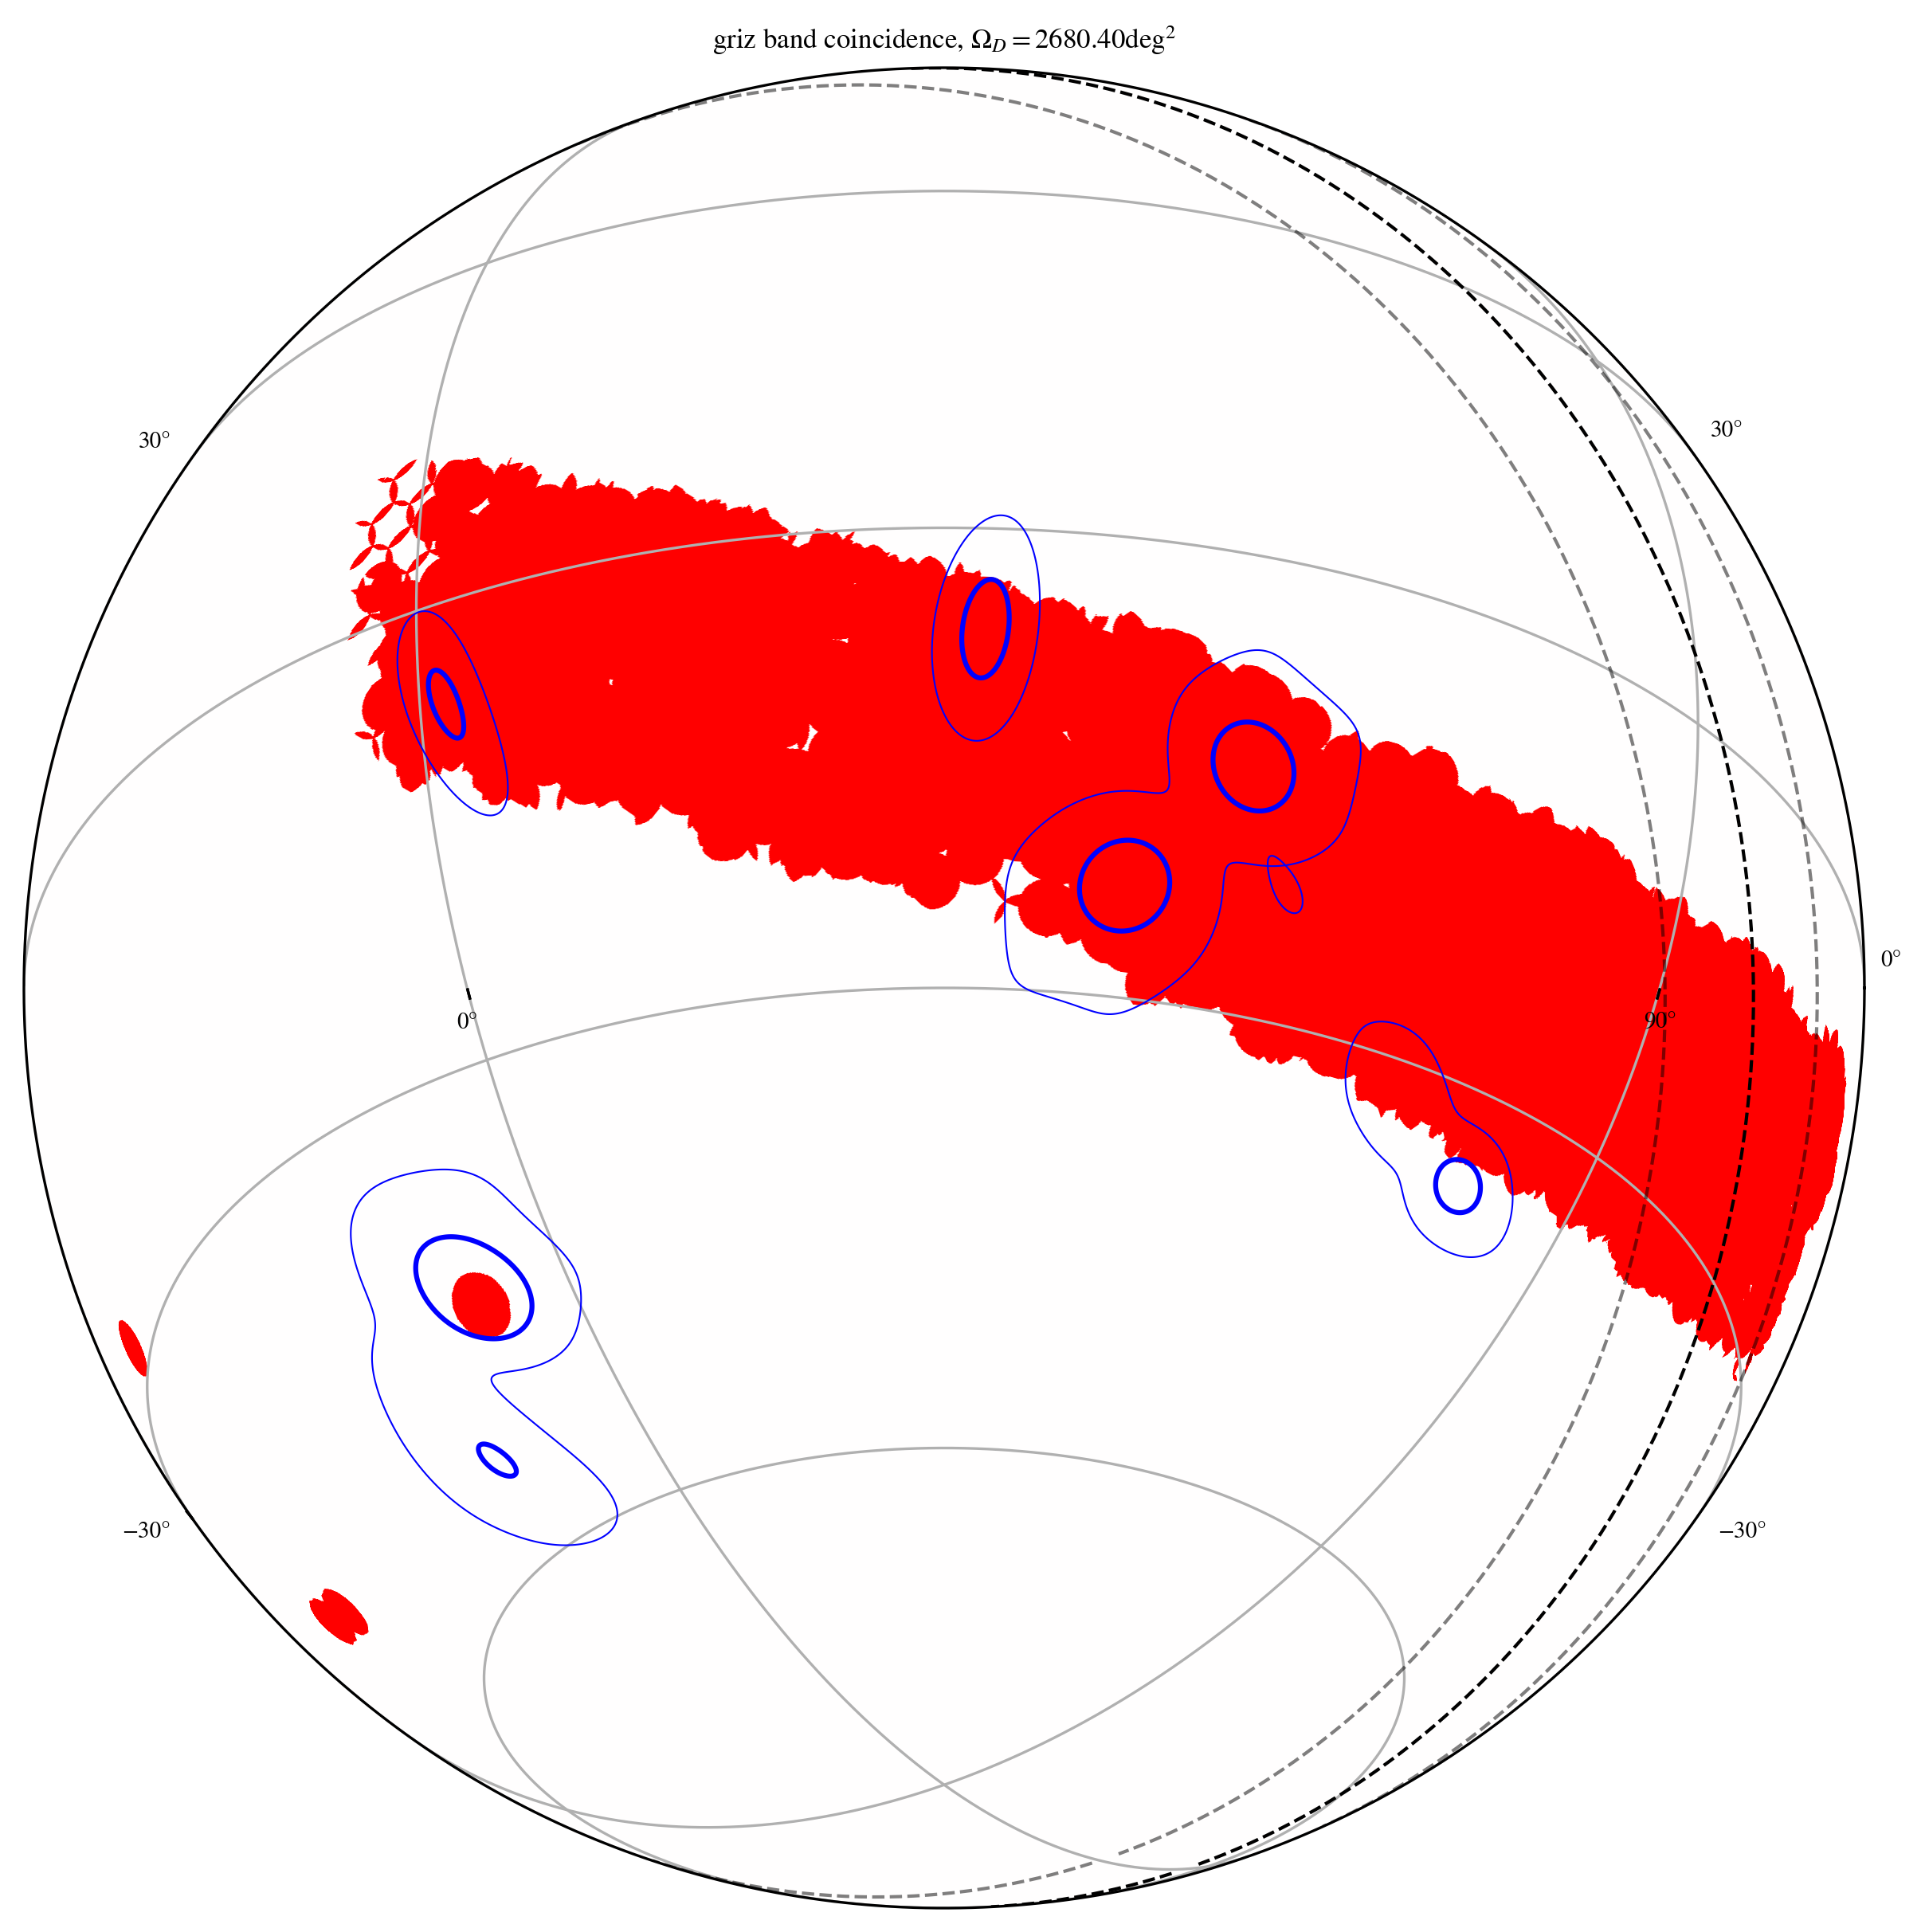

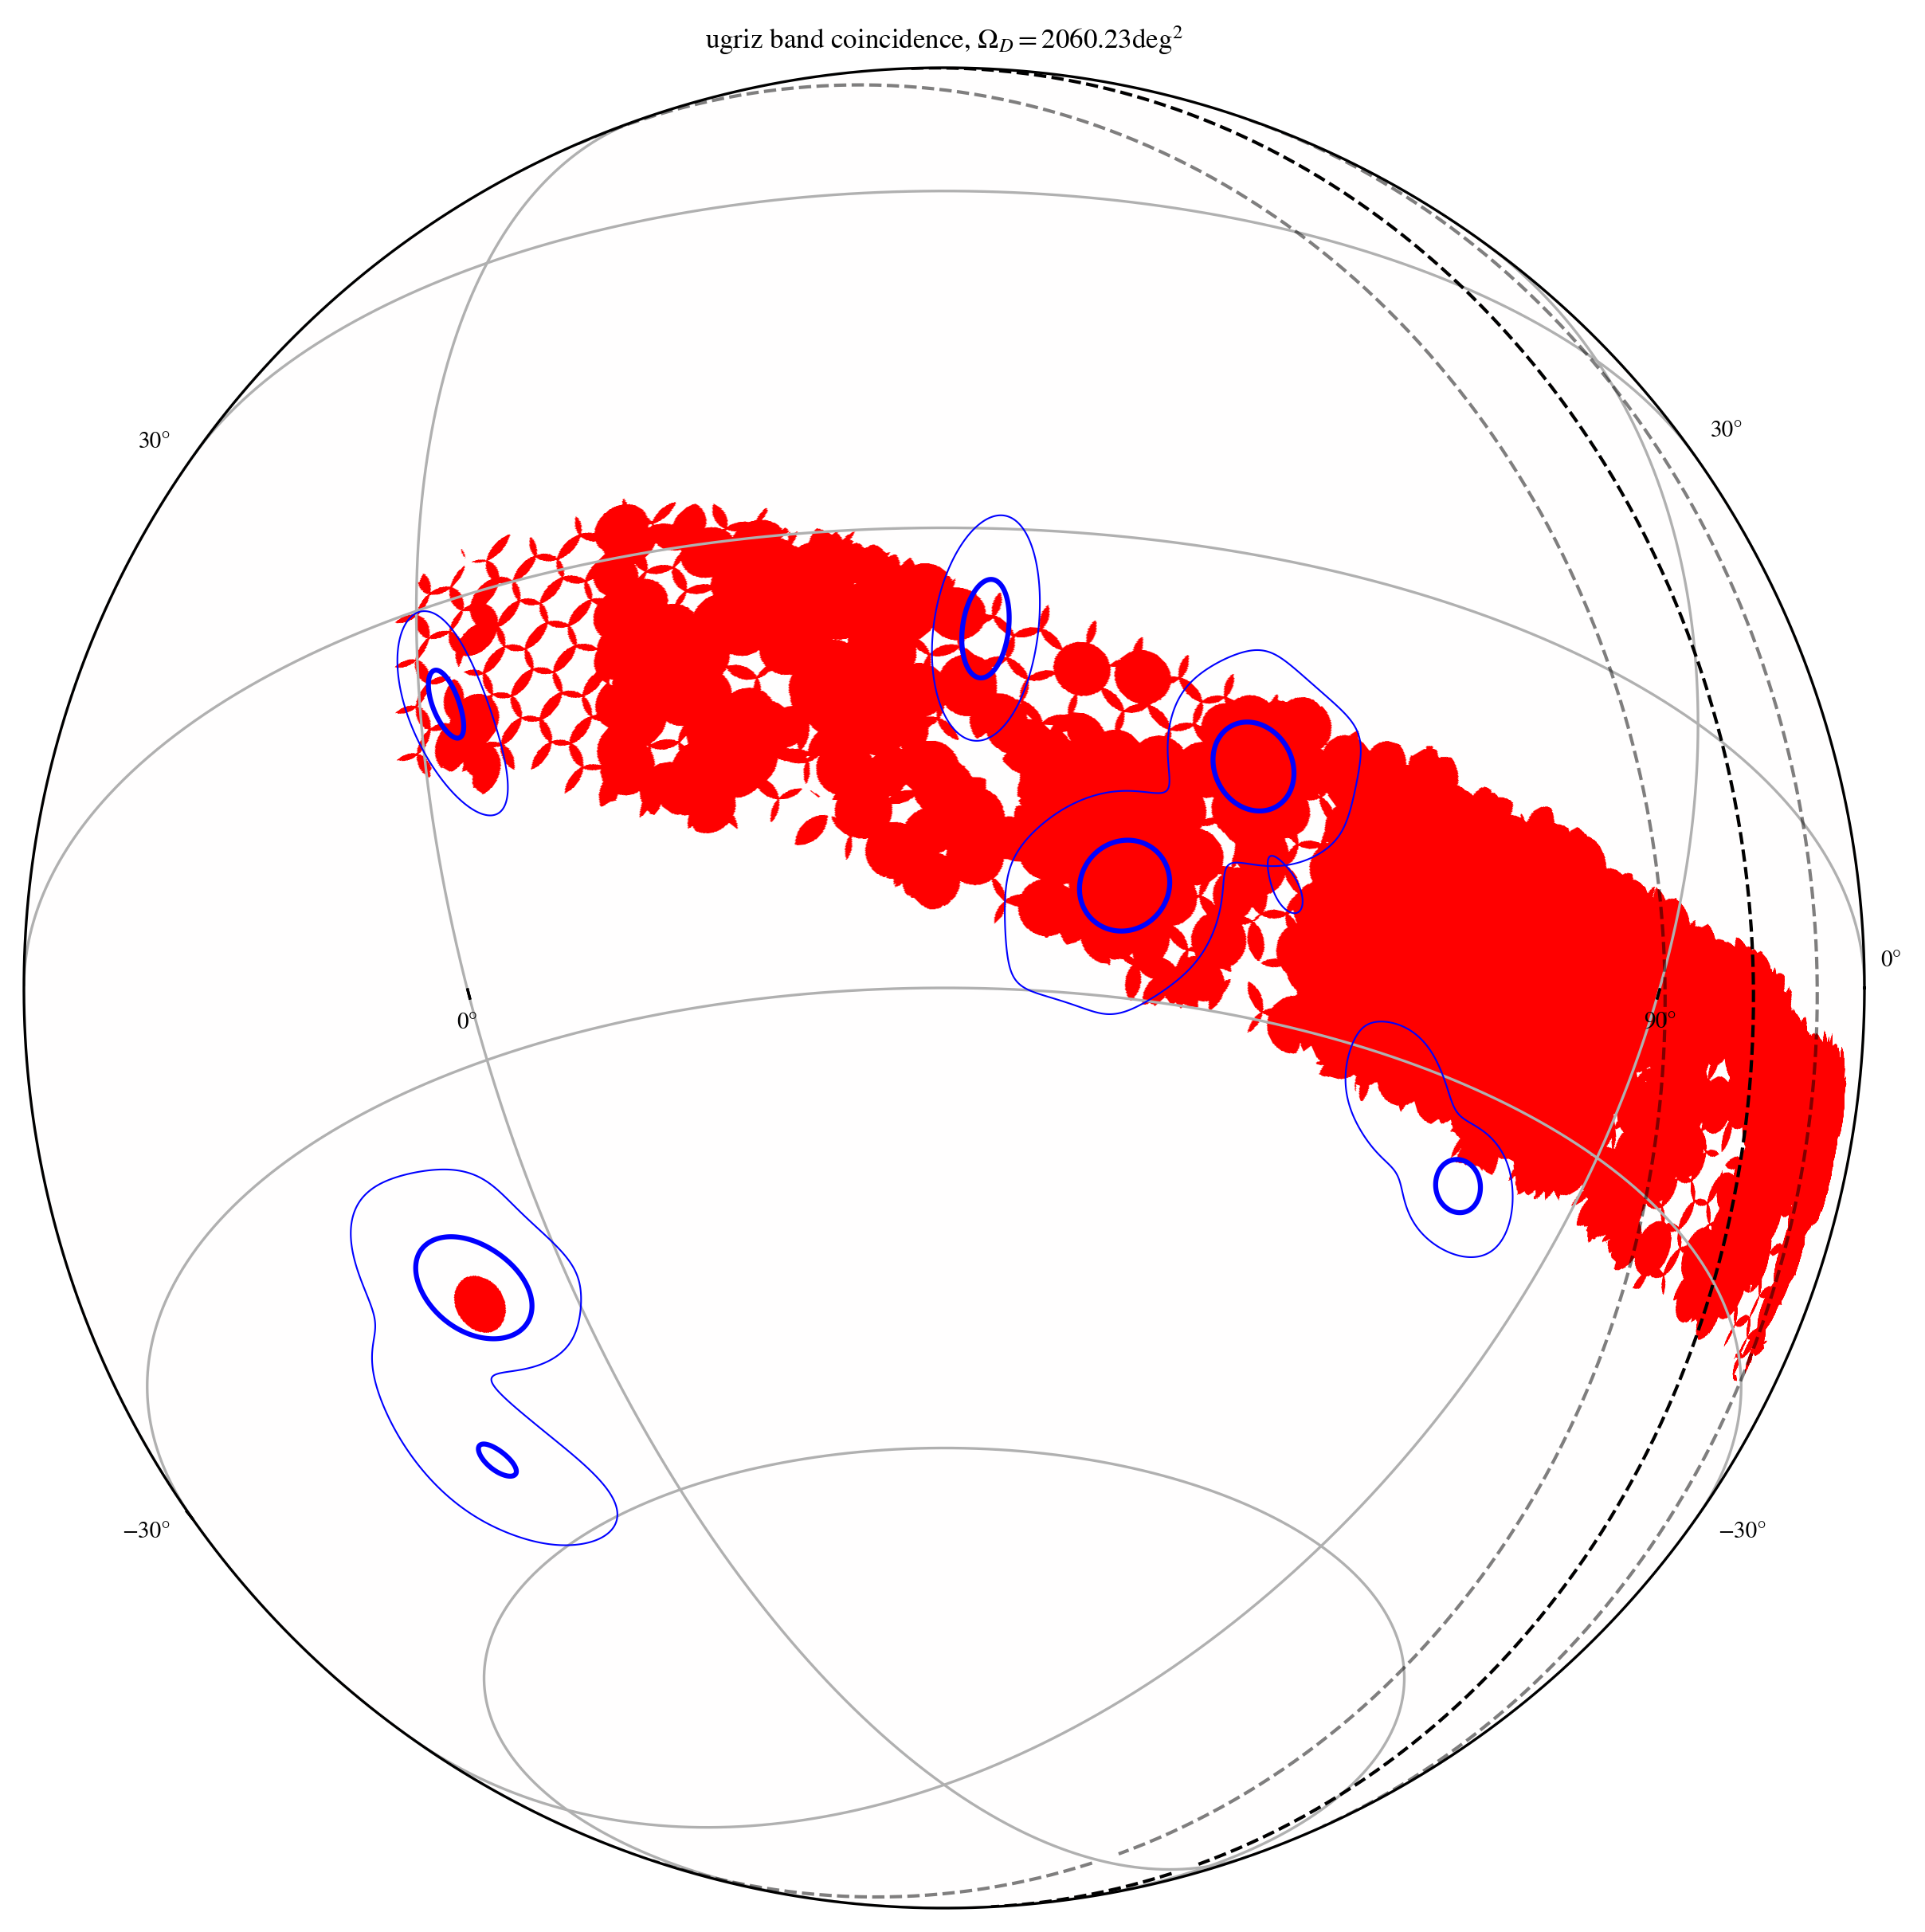

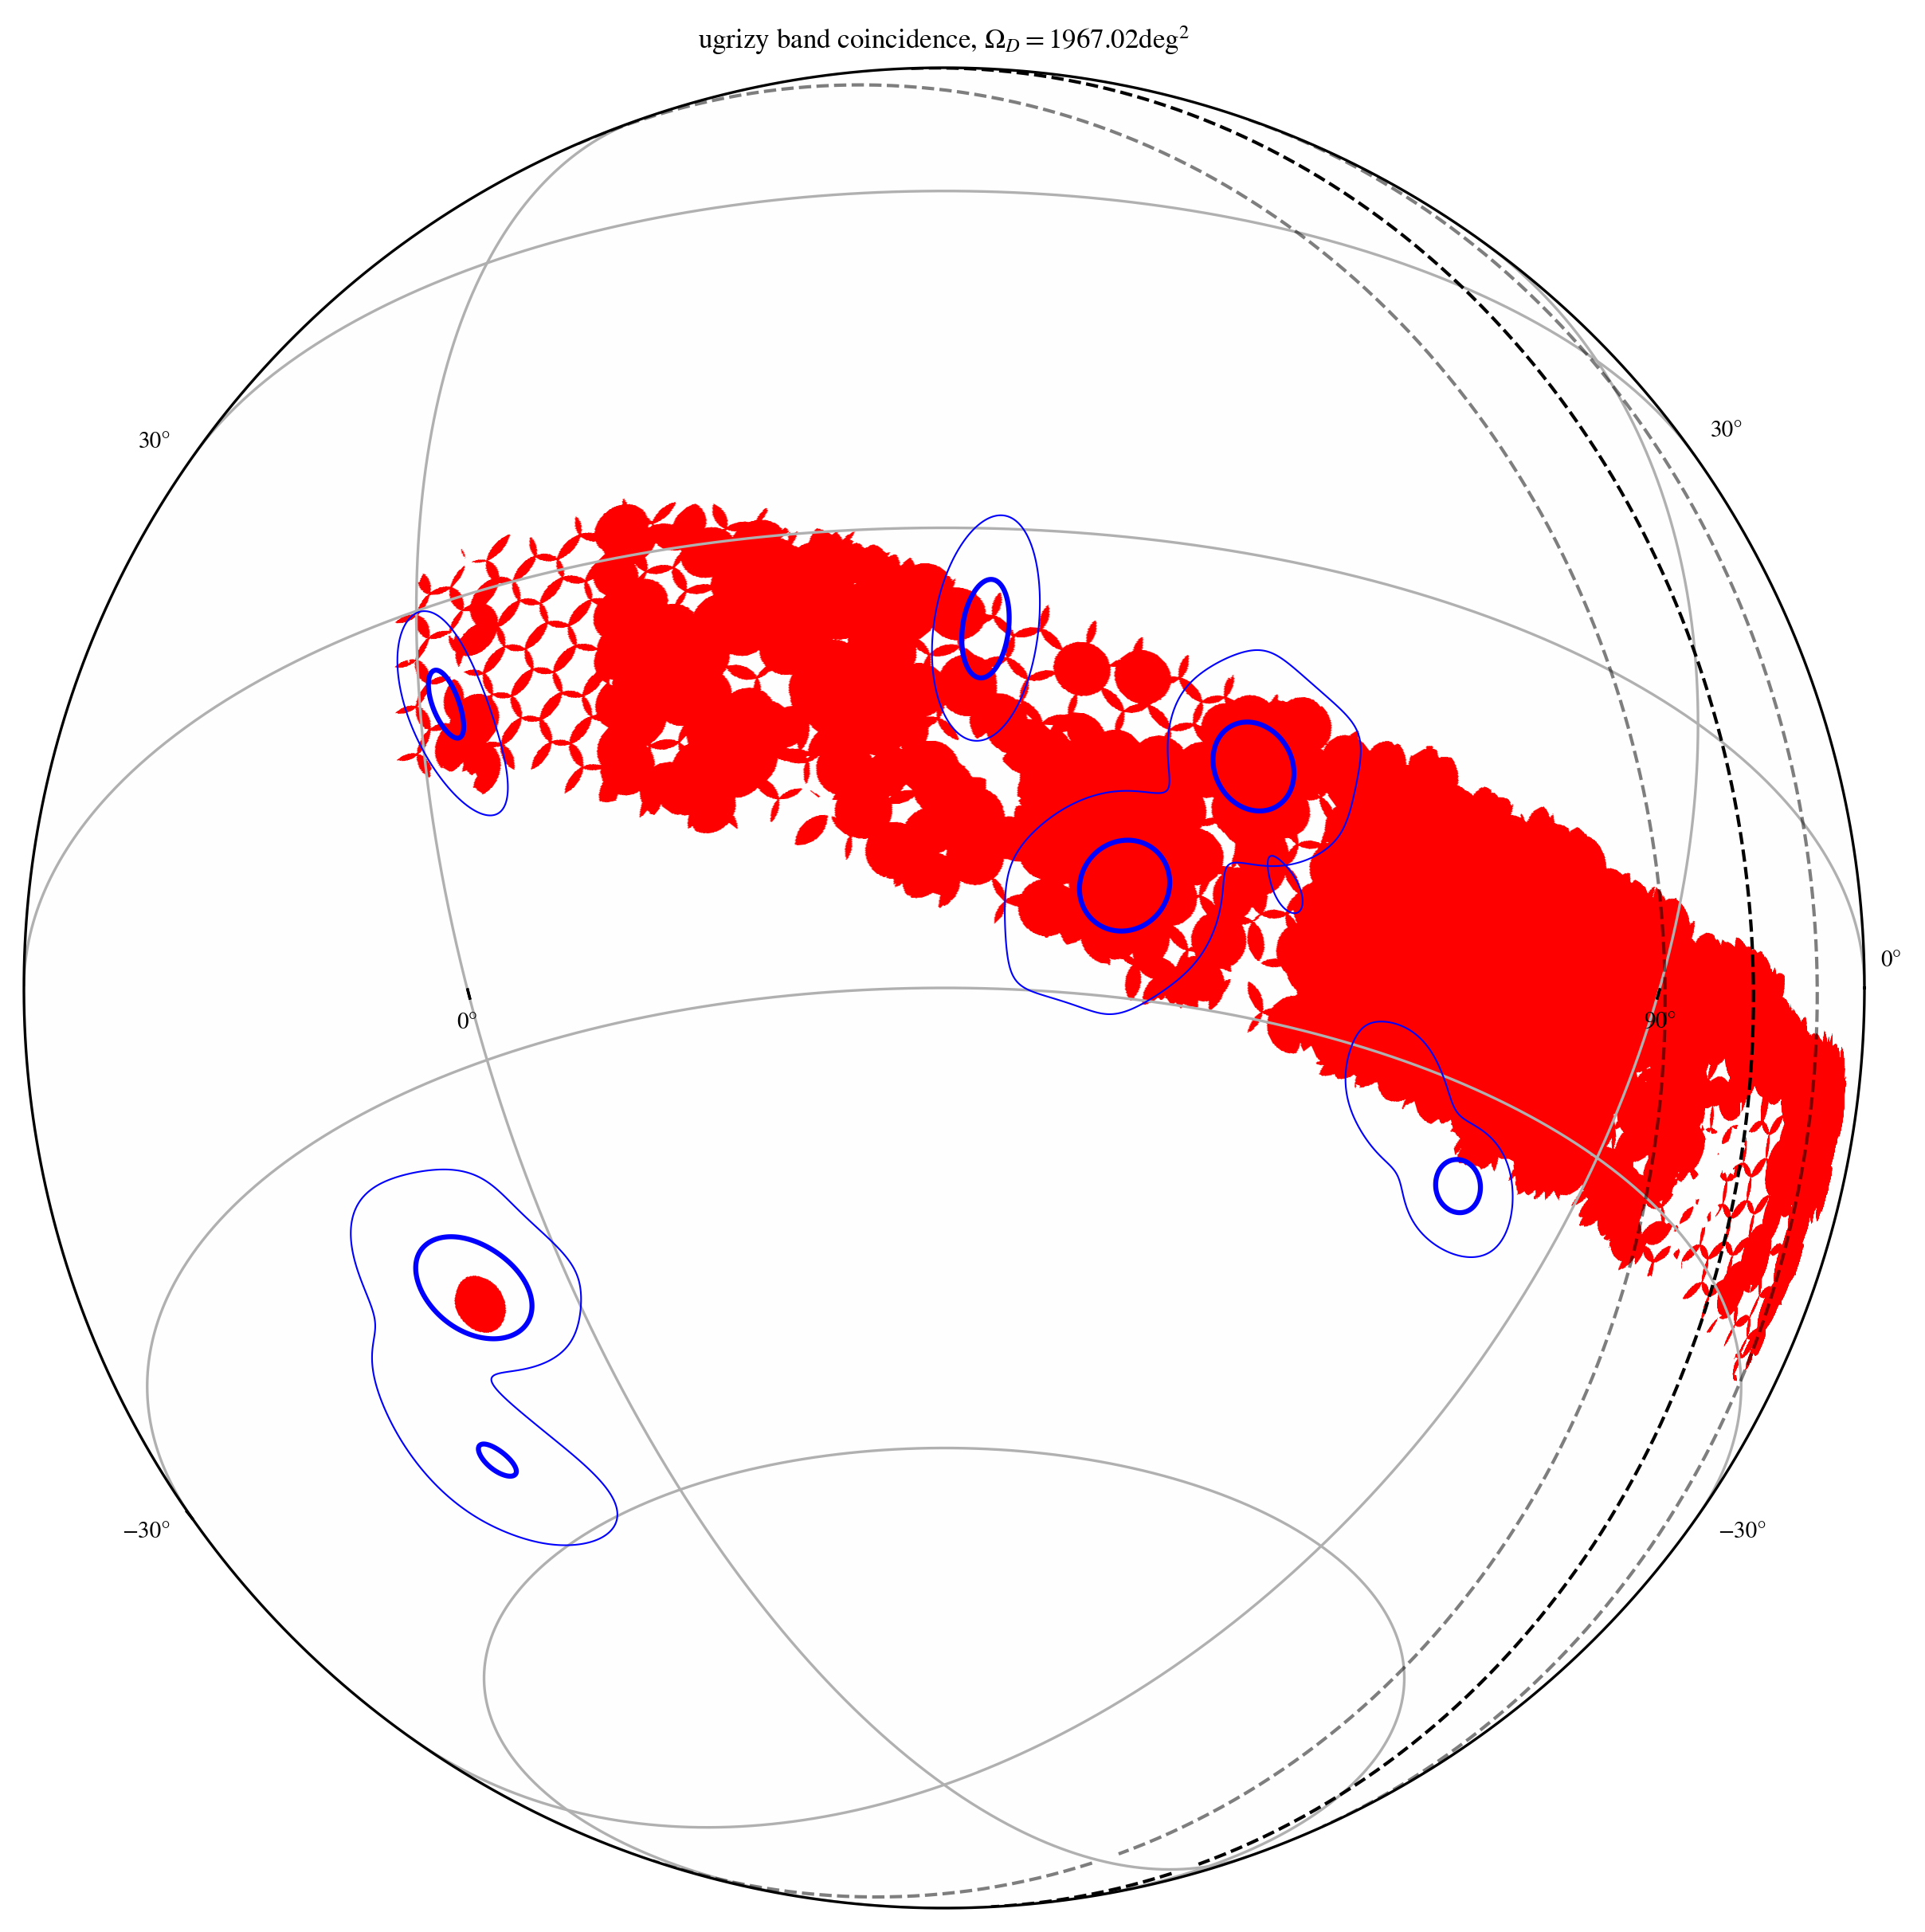

In [104]:
%%time 

for bandGroup in bandSet:
    fig = plt.figure(figsize=(10,10), dpi=300)
    
    ax = plt.axes(projection="geo globe",center="+35d -30d")
    bands=list(bandGroup)
    coincMap = np.zeros(len(visitMaps["u"]))
    for b in bands:
        indices = visitMaps[b]>=DESLims[b]
        coincMap[indices]+=1
    coincIndices = coincMap==len(bands)
    finMap = np.zeros(len(visitMaps["u"]))
    finMap[coincIndices]=1

    for coord, label, galkey in zip([galplane_md_coords, galplane_lo_coords, galplane_hi_coords],
                                ["Galactic center", "Galactic lower limit", "Galactic upper limit"],
                                galaxyKwargs.keys()):
        galRa = coord.icrs.ra
        galDec = coord.icrs.dec
        ax.plot(np.array(galRa)-90, galDec, linewidth=1, transform=ax.get_transform('icrs'), **galaxyKwargs[galkey])

    for i in range(len(skymaps)):
        topIndices = np.argsort(skymaps[i])[::-1][:2500]
        if (np.unique(finMap[topIndices])==True).any():
            ax.contour_hpx(skymaps[i], smooth=1*u.deg, levels=[level_arr50[i]], linewidths=1.5, colors='blue')
            ax.contour_hpx(skymaps[i], smooth=1*u.deg, levels=[level_arr90[i]], linewidths=0.5, linestyle='dashdot', colors='blue')

    
    c = ax.imshow_hpx(finMap,vmin=-1,vmax=1,cmap="bwr",alpha=1)
    # fig.colorbar(c,ax=ax,location='bottom',label="Number of visits")

    coincArea = hp.nside2pixarea(nside,degrees=True)*len(coincMap[finMap>0])
    
    ax.set_title("{} band coincidence, $\Omega_{}={:.2f} \deg ^2$".format(bandGroup,"D",coincArea))
    ax.grid()

    plt.savefig(f"{bandGroup}_DP2_coincident.jpg",dpi=300)

    del ax,fig

### Look at DECADE now

In [21]:
with open("hpixIds_decade.txt","r") as f:
    a = f.readlines()

In [22]:
realIds = []
for entry in a:
    realIds.append(int(entry[:-1]))

In [23]:
len(myMap[myMap>0])*hp.nside2pixarea(nside,degrees=True)

NameError: name 'myMap' is not defined

In [28]:
nside=32
decadeMap = np.zeros(hp.nside2npix(nside))
decadeMap[realIds]=1

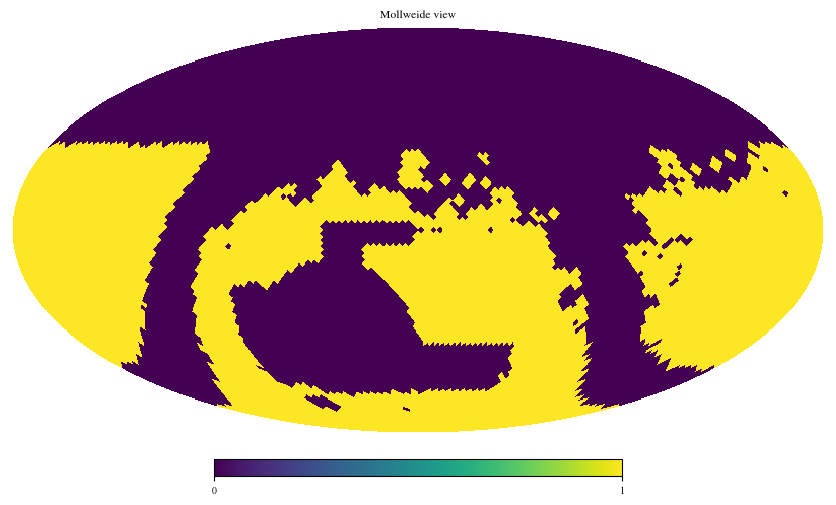

In [29]:
hp.mollview(decadeMap,min=0,max=1,nest=False,)

CPU times: user 855 ms, sys: 164 ms, total: 1.02 s
Wall time: 1.04 s


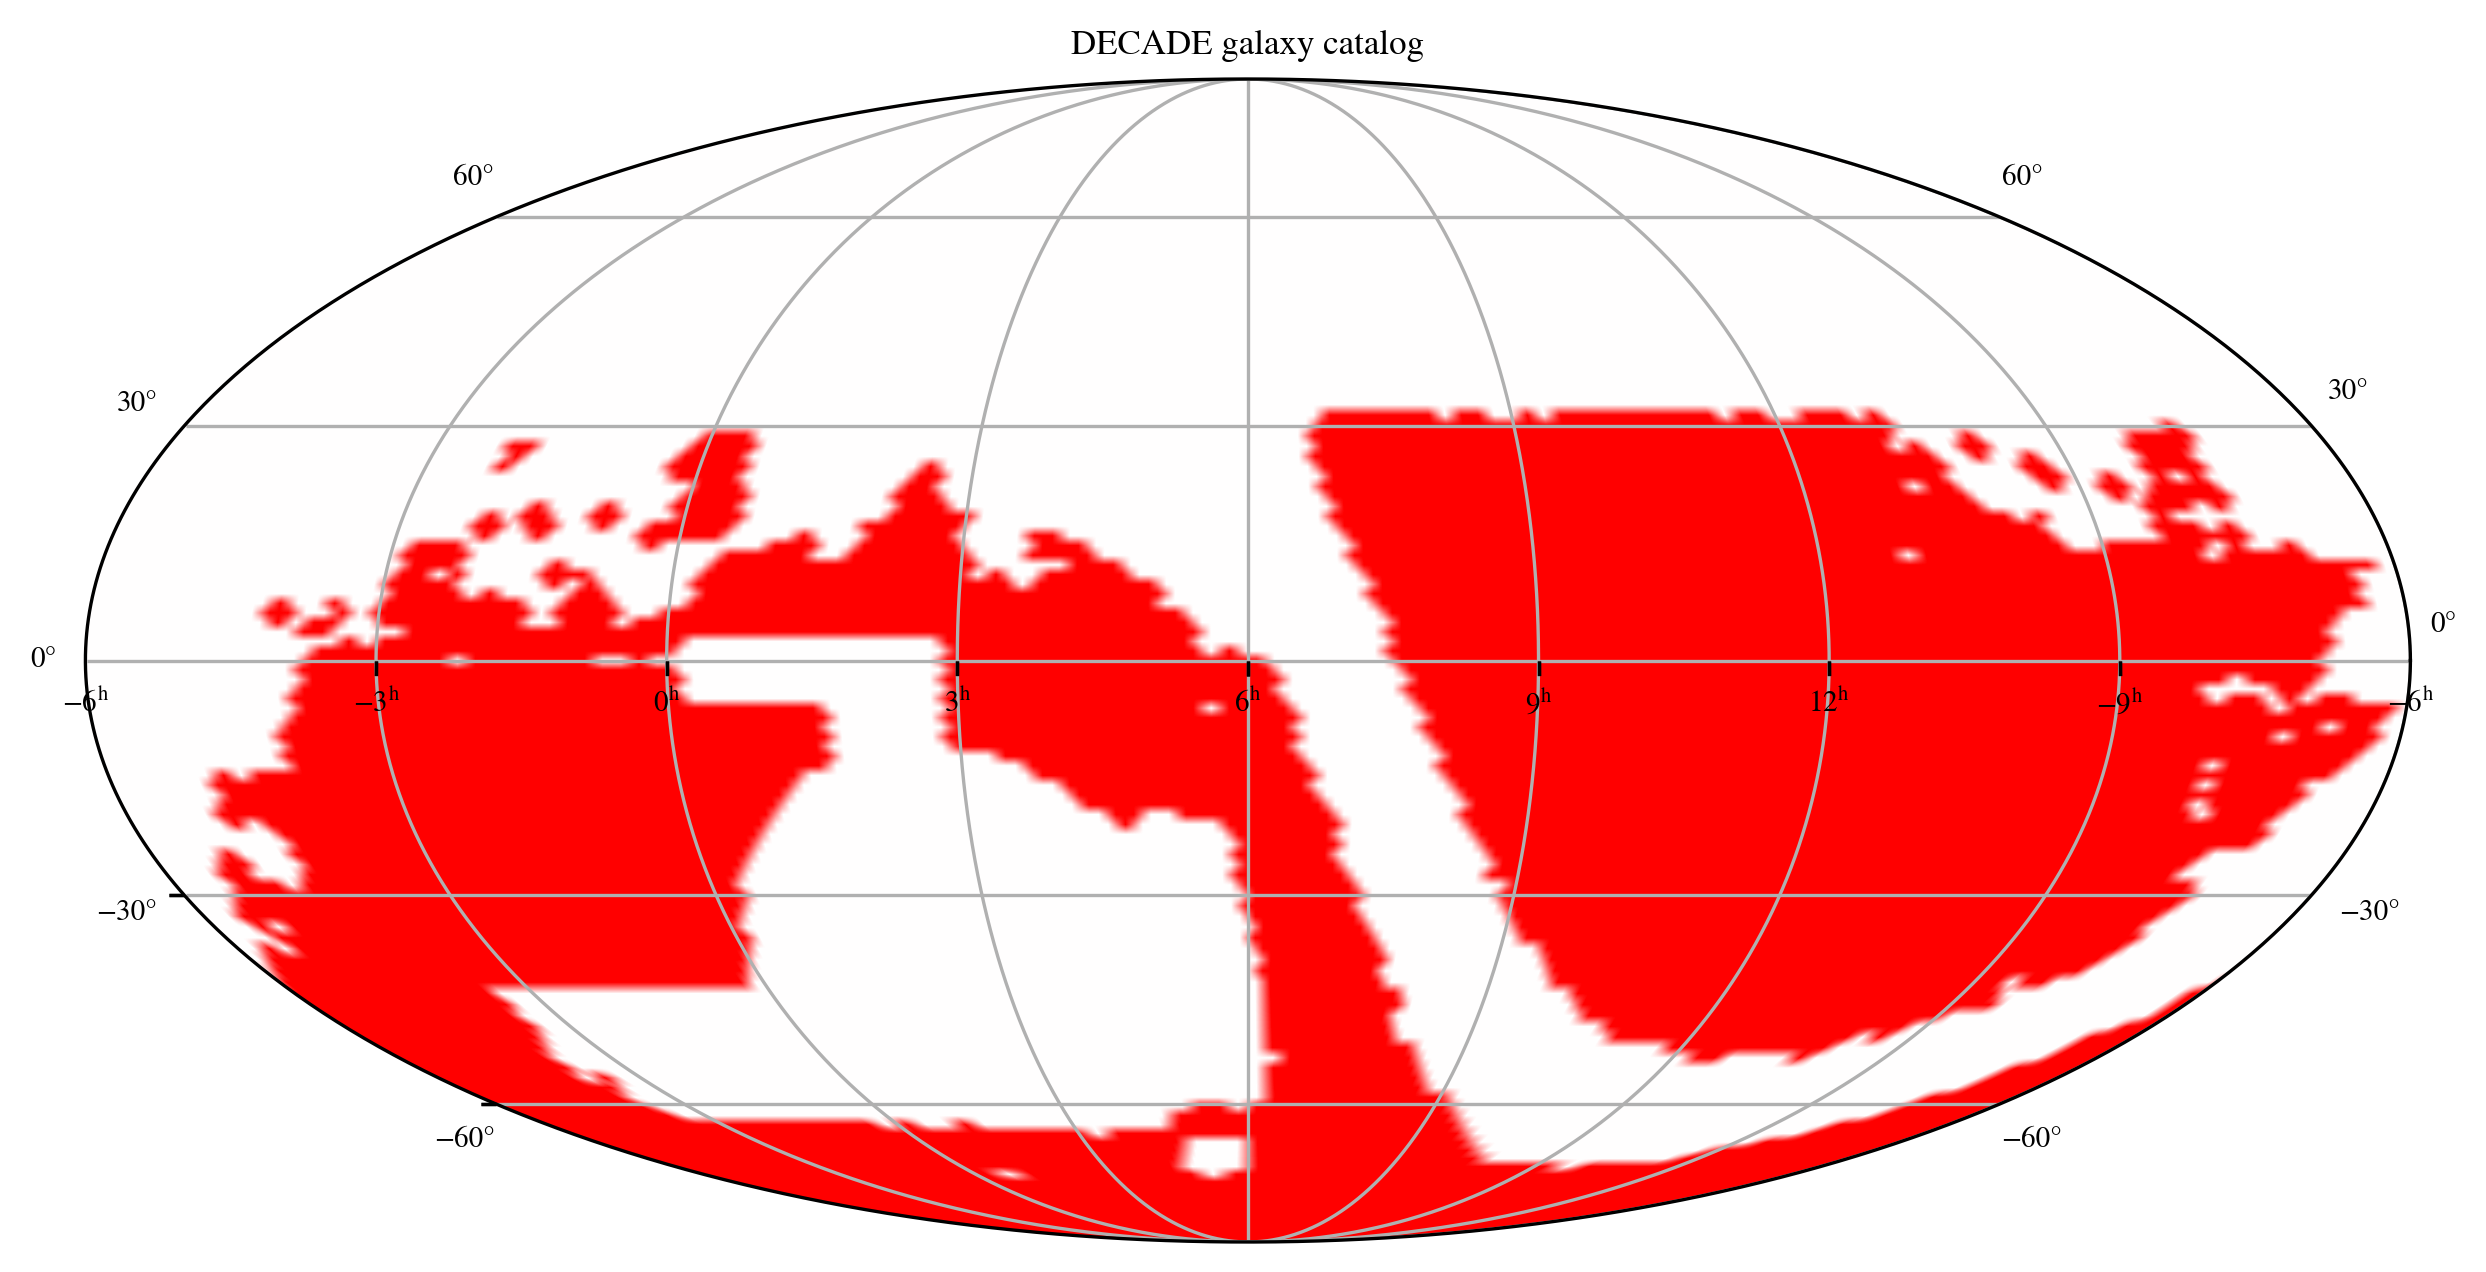

In [110]:
%%time 
fig = plt.figure(figsize=(10,6), dpi=300)

ax = plt.axes(projection="geo hours mollweide",center='+90d 0d')

# for i in range(len(skymaps)):
    # topIndices = np.argsort(hp.ud_grade(skymaps[i],32))[::-1][:2]
    # if (np.unique(decadeMap[topIndices])==True).any():
    # if True:
        # ax.contour_hpx(skymaps[i], smooth=1*u.deg, levels=[level_arr50[i]], linewidths=1.3, colors='dodgerblue')
        # ax.contour_hpx(skymaps[i], smooth=1*u.deg, levels=[level_arr90[i]], linewidths=1.3, linestyles = 'dashdot', colors='dodgerblue')


c = ax.imshow_hpx(decadeMap,vmin=-1,vmax=1,cmap="bwr",alpha=1)

coincArea = hp.nside2pixarea(nside,degrees=True)*len(coincMap[finMap>0])

# ax.set_title("DECADE galaxy catalog (red), and LVK events (blue) with $\Omega_{90} < 300 \deg ^2$ and $\Omega_{coinc} > 5 \deg ^2$")
# ax.set_title("DECADE galaxy catalog (red), and LVK events (blue) with $\Omega_{90} < 300 \deg ^2$")
ax.set_title("DECADE galaxy catalog")
ax.grid()

plt.savefig(f"DECADE_cov_allEvents.jpg",dpi=300)

del ax,fig